# Домашнее задание к семинару 06 (HW06)

## Импорты библиотек

In [37]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
accuracy_score, f1_score, roc_auc_score, confusion_matrix,
RocCurveDisplay, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier

from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = ARTIFACTS_DIR / "figures"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

## Загрузка данных и первичный анализ

In [98]:
df = pd.read_csv("S06-hw-dataset-01.csv")

In [99]:
df.shape

(12000, 30)

In [4]:
df.head()

,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
0,1,-0.946058,-0.070313,1.824445,-2.754422,0.808865,-0.111094,-0.268950,-3.078210,0.801275,...,-1.616515,-1.989464,1.407390,-0.218362,2.016052,0,2,3,33,0
1,2,-2.484027,0.739378,1.596908,-2.586479,-0.033225,-3.054412,-4.706908,-9.795169,0.145911,...,-1.727040,-0.583997,1.136761,0.285978,-0.310879,2,2,2,102,1
2,3,1.522629,7.159635,-0.564903,-4.493110,1.623610,5.450187,-0.974595,-5.189589,1.600591,...,0.524408,2.022430,1.278358,-0.850547,0.847457,1,0,2,3,0
3,4,0.463373,-1.073908,1.752813,0.362786,2.790872,4.082385,0.322283,3.390984,-0.033929,...,2.399834,-1.431576,-0.746987,0.049639,2.414689,1,0,1,50,0
4,5,3.188390,-4.701692,-0.689918,-0.448995,0.373821,-3.275363,-1.760931,0.923689,0.537345,...,-2.183407,-2.896590,2.440343,-1.097168,1.457323,1,2,3,81,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             12000 non-null  int64  
 1   num01          12000 non-null  float64
 2   num02          12000 non-null  float64
 3   num03          12000 non-null  float64
 4   num04          12000 non-null  float64
 5   num05          12000 non-null  float64
 6   num06          12000 non-null  float64
 7   num07          12000 non-null  float64
 8   num08          12000 non-null  float64
 9   num09          12000 non-null  float64
 10  num10          12000 non-null  float64
 11  num11          12000 non-null  float64
 12  num12          12000 non-null  float64
 13  num13          12000 non-null  float64
 14  num14          12000 non-null  float64
 15  num15          12000 non-null  float64
 16  num16          12000 non-null  float64
 17  num17          12000 non-null  float64
 18  num18 

In [6]:
print("Статистики:\n")
df.describe()

Статистики:



,id,num01,num02,num03,num04,num05,num06,num07,num08,num09,...,num20,num21,num22,num23,num24,cat_contract,cat_region,cat_payment,tenure_months,target
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,6000.50000,0.013705,-0.005278,-0.002357,0.038404,-0.006301,-0.865297,-0.702877,-0.290694,-0.008154,...,-0.323083,-1.314833,0.319798,-0.002742,0.027459,0.988750,1.990167,1.506833,36.083833,0.323417
std,3464.24595,2.096534,3.544498,1.004417,2.087318,1.007329,3.888966,1.989513,3.455981,0.996677,...,2.167066,3.731384,2.223649,0.996454,1.882359,0.815687,1.411643,1.121558,25.061218,0.467800
min,1.00000,-8.155181,-14.605579,-4.374043,-7.753301,-3.999332,-15.238402,-7.377252,-13.853627,-3.794637,...,-8.371050,-14.249204,-8.638879,-3.532093,-7.923990,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3000.75000,-1.423844,-2.303772,-0.685618,-1.374579,-0.676552,-3.532054,-2.064888,-2.597019,-0.683959,...,-1.808969,-3.863063,-1.097700,-0.676150,-1.110822,0.000000,1.000000,0.000000,17.000000,0.000000
50%,6000.50000,-0.047565,0.053348,-0.009186,0.038766,-0.003728,-1.092517,-0.795907,-0.208245,-0.020883,...,-0.383940,-1.393400,0.431804,0.006297,0.279689,1.000000,2.000000,2.000000,30.000000,0.000000
75%,9000.25000,1.422676,2.335937,0.671441,1.484417,0.669269,1.526389,0.522625,2.093169,0.666959,...,1.125140,1.116111,1.853491,0.657478,1.363896,2.000000,3.000000,3.000000,49.000000,1.000000
max,12000.00000,8.610863,16.299709,3.651692,7.571965,4.562115,16.223054,8.006444,13.030011,3.976868,...,7.957847,15.937281,8.102095,3.707905,7.549514,2.000000,4.000000,3.000000,120.000000,1.000000


In [7]:
print("Проверка типов столбцов:\n")
df.dtypes

Проверка типов столбцов:



id                 int64
num01            float64
num02            float64
num03            float64
num04            float64
num05            float64
num06            float64
num07            float64
num08            float64
num09            float64
num10            float64
num11            float64
num12            float64
num13            float64
num14            float64
num15            float64
num16            float64
num17            float64
num18            float64
num19            float64
num20            float64
num21            float64
num22            float64
num23            float64
num24            float64
cat_contract       int64
cat_region         int64
cat_payment        int64
tenure_months      int64
target             int64
dtype: object

In [8]:
print("Количество пропусков в столбцах:\n")
df.isna().sum()

Количество пропусков в столбцах:



id               0
num01            0
num02            0
num03            0
num04            0
num05            0
num06            0
num07            0
num08            0
num09            0
num10            0
num11            0
num12            0
num13            0
num14            0
num15            0
num16            0
num17            0
num18            0
num19            0
num20            0
num21            0
num22            0
num23            0
num24            0
cat_contract     0
cat_region       0
cat_payment      0
tenure_months    0
target           0
dtype: int64

In [9]:
print("Распределение target:\n")
df["target"].value_counts(normalize=True)

Распределение target:



target
0    0.676583
1    0.323417
Name: proportion, dtype: float64

In [10]:
feature_cols = [col for col in df.columns if col not in ["target", "id"]]
X = df[feature_cols]
y = df["target"]

In [119]:
for col in feature_cols:
    unique_vals = X[col].nunique()
    print(f"  {col}: {unique_vals} уникальных значений", end="")
    if unique_vals < 10:
        print(" (категориально-подобный) ")
    else:
        print(" (непрерывный)")

  num01: 12000 уникальных значений (непрерывный)
  num02: 12000 уникальных значений (непрерывный)
  num03: 12000 уникальных значений (непрерывный)
  num04: 12000 уникальных значений (непрерывный)
  num05: 12000 уникальных значений (непрерывный)
  num06: 12000 уникальных значений (непрерывный)
  num07: 12000 уникальных значений (непрерывный)
  num08: 12000 уникальных значений (непрерывный)
  num09: 12000 уникальных значений (непрерывный)
  num10: 12000 уникальных значений (непрерывный)
  num11: 12000 уникальных значений (непрерывный)
  num12: 12000 уникальных значений (непрерывный)
  num13: 12000 уникальных значений (непрерывный)
  num14: 12000 уникальных значений (непрерывный)
  num15: 12000 уникальных значений (непрерывный)
  num16: 12000 уникальных значений (непрерывный)
  num17: 12000 уникальных значений (непрерывный)
  num18: 12000 уникальных значений (непрерывный)
  num19: 12000 уникальных значений (непрерывный)
  num20: 12000 уникальных значений (непрерывный)
  num21: 12000 уника

## Train/Test-сплит и воспроизводимость

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

In [12]:
print("Количество данных на train и test:\n")
print(f"Данных на train {X_train.shape}, данных на test {X_test.shape}")

Количество данных на train и test:

Данных на train (9000, 28), данных на test (3000, 28)


В данном датасете неравномерное распределение классов (дисбаланс классов), поэтому необходимо использовать стратификацию для сохранения распределения на train и test, seed нужен для воспроизводимости, чтобы каждый раз мы получали один и тот же результат.

# Вспомогательные функции

In [124]:
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    m ={
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred))
    }
    if y_proba is not None:
        try:
            m["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except:
            m["roc_auc"] = None
    else: 
        m["roc_auc"] = None
    return m

def evaluate_on_test(model, X_test, y_test, label: str) -> dict:
    pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    metrics = compute_metrics(y_test, pred, proba)
    metrics["model"] = label
    return metrics

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def plot_confusion(y_true, y_test, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, str(val), ha="center", va="center")
    plt.savefig("artifacts/figures/Confusion_matrix.png")
    plt.show()

def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("Модель не содержит predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    plt.savefig("artifacts/figures/Roc-curve.png")
    plt.show()

# Baseline’ы

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_models = {}
search_summaries = {}

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
results.append(evaluate_on_test(dummy, X_test, y_test, "DummyClassifier(most_frequent)"))
best_models["DummyClassifier(most_frequent)"] = dummy

lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
])

lr_grid = {
    "lr__C": [0.01, 0.1, 0.3, 0.5, 1, 3, 5, 10, 15],
    #"lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"]
}

lr_search = GridSearchCV(
    lr, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
best_models["LogisticRegression"] = best_lr

search_summaries["LogisticRegression"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}
results.append(evaluate_on_test(best_lr, X_test, y_test, "LogisticRegression"))


In [15]:
print("METRICS\n\n")
print(results)
print("\n\nBEST_MODELS\n\n")
print(best_models)

METRICS


[{'accuracy': 0.6766666666666666, 'f1': 0.0, 'roc_auc': 0.5, 'model': 'DummyClassifier(most_frequent)'}, {'accuracy': 0.8296666666666667, 'f1': 0.7146845337800112, 'roc_auc': 0.878905083540704, 'model': 'LogisticRegression'}]


BEST_MODELS


{'DummyClassifier(most_frequent)': DummyClassifier(random_state=42, strategy='most_frequent'), 'LogisticRegression': Pipeline(steps=[('scaler', StandardScaler()),
                ('lr',
                 LogisticRegression(C=10, max_iter=4000, random_state=42))])}


**Вывод:**

DummyClassifier (accuracy=0.677) всегда предсказывает самый частый класс (ROC-AUC=0.5 - случайность).
LogisticRegression (accuracy=0.82, ROC-AUC=0.879) значительно лучше:
- +15.3 по accuracy
- Разделяющая способность намного лучше (ROC-AUC >> 0.5)

# Модели недели 6 

In [16]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [17]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
df_grid={
    "max_depth": [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [1, 5, 10, 15, 20, 25, 30, 35],
    "ccp_alpha": [0.0, 0.00001, 0.001, 0.002, 0.005, 0.01]
}
df_search = run_search("DecisionTree", dt, df_grid)
search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 1e-05,
  'max_depth': None,
  'min_samples_leaf': 30},
 'best_cv_roc_auc': 0.913189149571578}

In [19]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=4,
    oob_score=False
)
rf_grid = {
    "max_features": ["sqrt", 0.3, 0.5],
    "min_samples_leaf": [1, 5, 10],
    "max_depth": [None, 3, 5, 10, 20, 25]
}
rf_search = run_search("RandomForest", rf, rf_grid)
search_summaries["RandomForest"]

C:\Users\ivmsa\course-aie-group-2\homeworks\HW06\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'best_params': {'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.968266801113962}

In [20]:
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)
hgb_grid = {
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.15],
    "max_depth": [None, 1, 2, 3],
    "max_leaf_nodes": [10, 15, 30, 40, 60, 75, 80]
}
hgb_search = run_search("HistGradientBoosting", hgb, hgb_grid)
search_summaries["HistGradientBoosting"]

C:\Users\ivmsa\course-aie-group-2\homeworks\HW06\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'best_params': {'learning_rate': 0.1,
  'max_depth': None,
  'max_leaf_nodes': 75},
 'best_cv_roc_auc': 0.972759214953496}

In [21]:
estimators = [
    ("lr", best_models["LogisticRegression"]),
    ("dt", best_models["DecisionTree"]),
    ("rf", best_models["RandomForest"]),
    ("hgb", best_models["HistGradientBoosting"])
]
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=4000, random_state=RANDOM_STATE),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
stack.fit(X_train, y_train)
best_models["Stacking"] = stack
results.append(evaluate_on_test(stack, X_test, y_test, "Stacking"))

# Метрики качества

In [24]:
df = pd.DataFrame(results)

df_sorted = df.copy()
df_sorted["roc_auc_full"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc", "accuracy"], ascending=False).drop(columns=["roc_auc_full"])

df_sorted

,accuracy,f1,roc_auc,model
4,0.939000,0.902400,0.975130,HistGradientBoosting
5,0.942000,0.907937,0.973570,Stacking
3,0.933333,0.892009,0.970125,RandomForest
2,0.866000,0.792784,0.918180,DecisionTree
1,0.829667,0.714685,0.878905,LogisticRegression
0,0.676667,0.000000,0.500000,DummyClassifier(most_frequent)


# Лучшая модель

In [93]:
best_mod = df_sorted.iloc[0]
best_label = best_mod["model"]
best_model = best_models[best_label]

y_pred = best_model.predict(X_test)


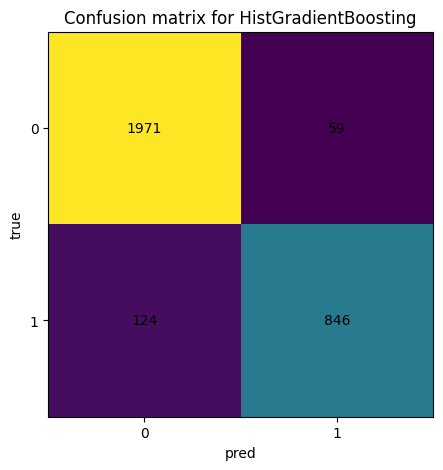

In [125]:
plot_confusion(y_test, y_pred, title=f"Confusion matrix for {best_label}")

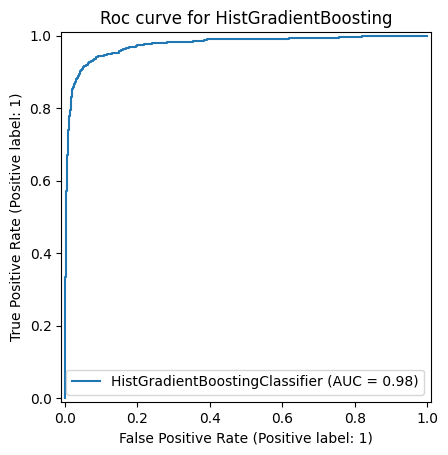

In [105]:
plot_roc(best_model, X_test, y_test, title=f"Roc curve for {best_label}")

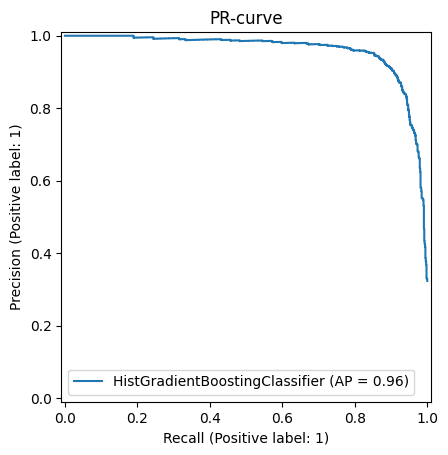

In [111]:
PrecisionRecallDisplay.from_estimator(
    best_model,
    X_test,
    y_test
)

plt.title("PR-curve")
plt.savefig("artifacts/figures/PR-кривая.png")
plt.show()

# Интерпретация

In [72]:
feature_names = list(X_train.columns)

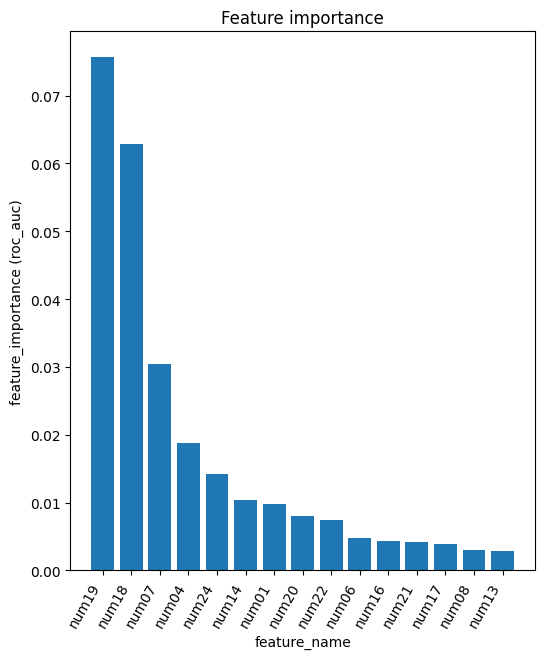

In [123]:
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

permutation = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = permutation.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(6, 7))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.xlabel("feature_name")
plt.ylabel(f"feature_importance ({scoring})")
plt.title("Feature importance")
plt.savefig("artifacts/figures/Feature_importance.png")
plt.show()

## **Вывод**
Категориально-подобные признаки не вошли в 15 наиболее важных признаков.
Это получилось из-за того, что у категориально-подобных признаков небольшой диапазон значений, поэтому деревья могут сделать по ним мало разбиений и модель получает мало информации.
Непрерывные признаки дают больше возможностей для оптимизации.

# Артефакты эксперимента

In [84]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


In [113]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)
print("Saved:", model_path)

Saved: artifacts\best_model.joblib


In [114]:
meta = {
    "best_model_label": best_label,
    "test_metrics": best_mod.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")
print("Saved", ARTIFACTS_DIR / "best_model_meta_json")

Saved artifacts\best_model_meta_json
